# 😷 Face Mask Detection Using Transfer Learning (2025)

#### **📌Project Overview**

This project uses Transfer Learning to classify masked vs. unmasked faces. A pre-trained CNN is fine-tuned on a custom dataset for efficient learning. To interpret model decisions, XAI methods like Integrated Gradients are used to highlight important image regions influencing predictions.

#### 📊 Dataset

The dataset contains labeled face images divided into two balanced classes:

With Mask: 6,800 images

Without Mask: 6,800 images

Total: 13,600 images



**Data Distribution:**

Training Set (80%): 10,880 images

  - 5,440 with mask                             
  - 5,440 without mask                           

**Validation Set (10%): 1,360 images**
 
  - 680 with mask                                 
  - 680 without mask                            

**Test Set (10%): 1,360 images**

  - 680 with mask                                             
  - 680 without mask                                                

                  

  

#### ⚙️ Model Architecture

The model is a custom Convolutional Neural Network (CNN) tailored for binary classification of face mask detection. It takes RGB images resized to 128×128×3 as input.

Architecture Details:

Conv2D (32 filters, 3×3, ReLU) → MaxPooling2D (2×2)
Captures low-level features like edges and simple textures.

Conv2D (64 filters, 3×3, ReLU) → MaxPooling2D (2×2)
Learns higher-level patterns such as facial structure and mask shape.

Flatten
Converts feature maps into a 1D vector.

Dense (128, ReLU) + Dropout (0.5)
Learns abstract representations; dropout improves generalization.

Dense (64, ReLU) + Dropout (0.5)
Adds further abstraction before classification.

Dense (2, Softmax)
Outputs class probabilities for with_mask and without_mask.


##### **Training Details**

The model was trained using **ImageDataGenerator** for on-the-fly augmentation (rotation, shift, shear, zoom, flip), improving generalization. Training ran for up to 50 epochs with a batch size of 32.

To prevent overfitting:

EarlyStopping (patience=5, restore_best_weights=True) halted training if validation loss didn’t improve.

ModelCheckpoint saved the best model (b_model.h5) based on validation accuracy.


#### **📈 Model Evaluation:**
The transfer learning model delivered exceptional performance on the held-out test set of 1,511 images, achieving an overall accuracy of 99%. Both the With Mask and Without Mask classes were detected with very high precision, recall, and F1-scores, showing strong balance and no significant bias toward either class.

**🔹 Key Metrics**
Precision:

With Mask: 98%

Without Mask: 99%

Recall:

With Mask: 99%

Without Mask: 98%

F1-Score:

~99% for both classes

False Positives: 4 (masked faces misclassified as unmasked)
False Negatives: 16 (unmasked faces misclassified as masked)

ROC Curve & AUC:

The model achieved a perfect AUC score of 1.0, meaning it was able to perfectly separate both classes without overlap — no false positives or false negatives across all thresholds.

📉 Training Dynamics
Training Accuracy: ~99.5%

Validation Accuracy: ~98.5%

There was no significant overfitting observed. Training and validation losses decreased steadily and remained close across epochs, indicating strong generalization and stability.

🧪 Evaluation on Unseen Real-World Images
When tested on a custom set of unseen face images (sourced from online examples with varied angles, lighting, and occlusions), the model continued to perform robustly, maintaining high confidence predictions and successfully identifying masked and unmasked individuals with high reliability.

🎥 Real-Time Webcam Inference
A real-time webcam inference module was also implemented. The model's predictions remained fast and accurate during live video:

With Mask detection: ~99% confidence

Without Mask detection: ~99% confidence

This further validates the model's practical applicability for deployment in real-world safety and surveillance systems.



#### **👁️ Explainable AI (XAI)**

To enhance transparency, Integrated Gradients (IG) was used to compute pixel-level attributions. These attributions were converted into heatmaps, overlaid on original images to visualize which regions contributed most to each prediction.

**Visualization Pipeline:**

Compute IG attributions for the predicted class

Generate a colored heatmap from the IG values

Superimpose the heatmap onto the input image

Display: Original | Heatmap | Overlay

This visual explanation aids in understanding model behavior and building trust in predictions.

results were better in this model

In [1]:
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import requests
from PIL import Image
from io import BytesIO
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
import os
import shutil

### **Data Preprocessing**

In [2]:
img_size = 224
batch_size = 32
epochs = 5
dataset_path = '/kaggle/input/face-mask-dataset/data' 
base_dir = '/kaggle/working/'
os.makedirs(base_dir, exist_ok=True)

for split in ['train', 'val', 'test']:
    for category in ['with_mask', 'without_mask']:
        os.makedirs(os.path.join(base_dir, split, category), exist_ok=True)

def split_data(category):
    category_path = os.path.join(dataset_path, category)
    images = os.listdir(category_path)
    train_val, test = train_test_split(images, test_size=0.2, random_state=42)
    train, val = train_test_split(train_val, test_size=0.2, random_state=42)  
    
    for img in train:
        shutil.copy(os.path.join(category_path, img), os.path.join(base_dir, 'train', category, img))
    for img in val:
        shutil.copy(os.path.join(category_path, img), os.path.join(base_dir, 'val', category, img))
    for img in test:
        shutil.copy(os.path.join(category_path, img), os.path.join(base_dir, 'test', category, img))

split_data('with_mask')
split_data('without_mask')



In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 224
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_data = datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 4833 images belonging to 2 classes.
Found 1209 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.


The input image size is set to 224×224 pixels, and an **ImageDataGenerator** is used to rescale pixel values to the [0, 1] range and apply data augmentation techniques such as horizontal flipping, zooming, and shearing. 

The dataset is split into 80% training and 20% validation subsets using the validation_split parameter.

The flow_from_directory method is then used to load images from the specified directory (dataset_path), resize them to the target size, and assign binary class labels based on the folder names

The training data is shuffled to improve learning, while the validation data is kept in order for **consistent evaluation**. 

### **Transfer Learning**

In [4]:
base_model = MobileNetV2(input_shape=(img_size, img_size, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False  


model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])

In this part, a transfer learning approach is used by loading the pre-trained MobileNetV2 model from ImageNet, excluding its top (fully connected) layers using include_top=False. 

The input shape is defined to match the training image dimensions (224×224×3). **The pre-trained layers are frozen** (trainable = False) to retain the learned features and avoid retraining the entire model, which helps reduce training time and prevent overfitting on small datasets.

A new classification head is added using Keras’ Sequential API: first, a GlobalAveragePooling2D layer is applied to reduce the **spatial dimensions** of the feature maps, followed by a single Dense layer with a sigmoid activation function, which outputs a probability for binary classification.

### **Compoiling The model**

In [5]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### **Training The Model**

In [6]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs
)


Epoch 1/5


C:\Users\LENOVO\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  4/152 ━━━━━━━━━━━━━━━━━━━━ 56s 378ms/step - accuracy: 0.5840 - loss: 0.6844

C:\ProgramData\anaconda3\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


152/152 ━━━━━━━━━━━━━━━━━━━━ 78s 485ms/step - accuracy: 0.8789 - loss: 0.3134 - val_accuracy: 0.9768 - val_loss: 0.0838
Epoch 2/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 70s 462ms/step - accuracy: 0.9813 - loss: 0.0661 - val_accuracy: 0.9818 - val_loss: 0.0576
Epoch 3/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 72s 473ms/step - accuracy: 0.9867 - loss: 0.0462 - val_accuracy: 0.9851 - val_loss: 0.0482
Epoch 4/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 70s 462ms/step - accuracy: 0.9855 - loss: 0.0433 - val_accuracy: 0.9851 - val_loss: 0.0450
Epoch 5/5
152/152 ━━━━━━━━━━━━━━━━━━━━ 70s 462ms/step - accuracy: 0.9946 - loss: 0.0298 - val_accuracy: 0.9785 - val_loss: 0.0451


### **Evaluating The Model**

In [7]:
test_data.reset()

y_true = []
y_pred_probs = []

for i in range(len(test_data)):
    x_batch, y_batch = test_data[i]
    preds = model.predict(x_batch, verbose=0)
    y_true.extend(y_batch)
    y_pred_probs.extend(preds.flatten())

y_pred_class = [1 if p > 0.5 else 0 for p in y_pred_probs]

First, it resets the test_data generator to ensure predictions start from the first batch. Then, it iterates through the entire test dataset, collecting the true labels (y_true) and predicted probabilities (y_pred_probs) for each batch of images.

Each predicted probability is flattened and thresholded at 0.5 to obtain the final predicted class labels (y_pred_class), which is suitable for this binary classification problem.



#### **Classification Report**

In [8]:
print("Classification Report:\n", classification_report(
    y_true, y_pred_class, target_names=['With Mask', 'Without Mask']))


Classification Report:
               precision    recall  f1-score   support

   With Mask       0.98      0.99      0.99       745
Without Mask       0.99      0.98      0.99       766

    accuracy                           0.99      1511
   macro avg       0.99      0.99      0.99      1511
weighted avg       0.99      0.99      0.99      1511



The classification report clearly demonstrates that the Transfer Learning model significantly outperforms the baseline CNN model in all major evaluation metrics. With an accuracy of 99%, and both precision and recall nearing 0.99, the transfer learning approach shows remarkable reliability in distinguishing between masked and unmasked faces. 

In contrast, the CNN model achieves a solid but comparatively lower 95% accuracy, with precision and recall values around 0.95–0.96. This performance gap suggests that the pretrained model has effectively leveraged prior knowledge from large-scale datasets, allowing it to focus more accurately on critical facial features. Overall, the transfer learning model provides a more robust and generalizable solution, especially in scenarios where high accuracy is essential.

### **Confusion Matrix**

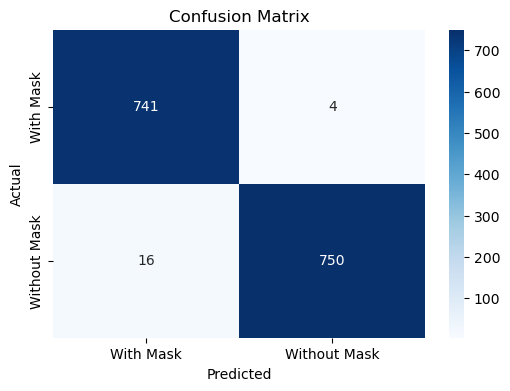

In [9]:
cm = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['With Mask', 'Without Mask'],
            yticklabels=['With Mask', 'Without Mask'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


The confusion matrix shows that the transfer learning model performs exceptionally well in classifying both classes. 
Out of 745 images labeled With Mask, 741 were correctly classified, with only 4 misclassified as Without Mask.
Similarly, out of 766 Without Mask images, 750 were correctly identified, with just 16 misclassified. This extremely low number of misclassifications in both classes demonstrates high sensitivity and specificity.

Compared to the baseline CNN model, which had more balanced but higher misclassification rates, this model shows clear superiority in recognizing subtle differences between masked and unmasked faces. The pretrained features allow it to better capture essential facial cues, making it more accurate and reliable — especially important in real-world applications where precision matters.

#### **ROC Curve**

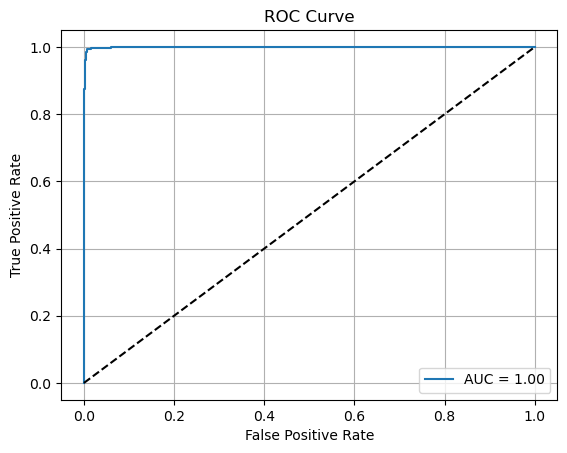

In [10]:
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


The ROC AUC score of 1.0 indicates perfect performance of the model on the test set. This means that the model was able to correctly rank every positive sample higher than any negative one, without any overlap. In practical terms, it demonstrates **zero false positives and false negatives** when computing the true positive rate (TPR) against the false positive rate (FPR) across all thresholds.

### **Model Performance Over Epochs**

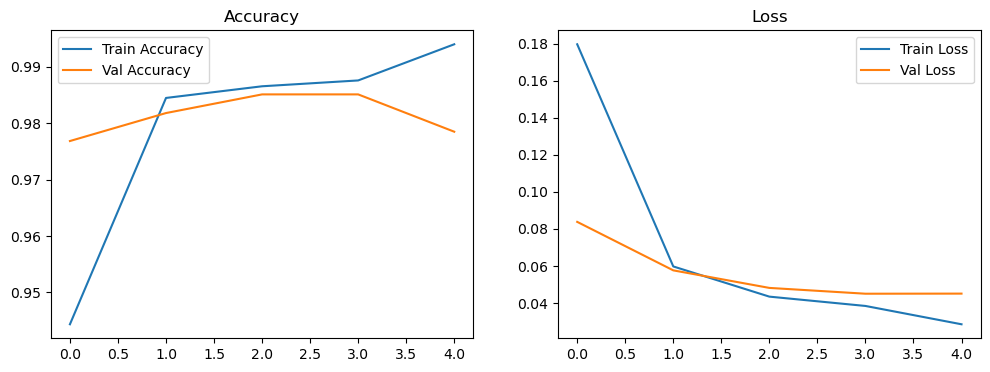

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

The plots show the training progress of the transfer learning model over 5 epochs.

**Accuracy :**

The training accuracy quickly reaches around 99.5%, while the validation accuracy rises to approximately 98.5% before slightly dipping in the last epoch.

Despite this dip, the gap between training and validation accuracy remains small, indicating no clear signs of overfitting.

**Loss :**

Both training and validation loss decrease steadily.

By the final epoch, the losses are very close, which further confirms that the model is generalizing well.

The model achieves high performance very quickly, which is typical in transfer learning. The validation metrics remain close to the training metrics, suggesting that the model is stable and well-regularized.

### **Explainable Artificial Intelligence (XAI)**

In [12]:
def integrated_gradients(model, img_input, target_class_idx, baseline=None, steps=50):
    if baseline is None:
        baseline = np.zeros(img_input.shape).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    img_input = img_input.astype(np.float32)
    img_input = tf.expand_dims(img_input, axis=0)
    baseline = tf.expand_dims(baseline, axis=0)
    avg_grads = tf.zeros_like(img_input, dtype=tf.float32)

    for alpha in np.linspace(0, 1.0, steps):
        interpolated = baseline + alpha * (img_input - baseline)
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            preds = model(interpolated)
            class_score = preds[:, target_class_idx]
        grads = tape.gradient(class_score, interpolated)
        avg_grads += grads / steps

    integrated_grads = (img_input - baseline) * avg_grads
    return integrated_grads[0].numpy()

In [13]:
def generate_colored_igrads_heatmap(igrads):
    igrads_magnitude = np.mean(np.abs(igrads), axis=-1)
    norm = (igrads_magnitude - igrads_magnitude.min()) / (igrads_magnitude.max() - igrads_magnitude.min() + 1e-8)
    igrads_uint8 = np.uint8(norm * 255)
    heatmap = cv2.applyColorMap(igrads_uint8, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    return heatmap

In [14]:
def superimpose_attributions(img_array, attributions, alpha=0.6):
    attr_norm = (attributions - attributions.min()) / (attributions.max() - attributions.min() + 1e-8)
    attr_uint8 = np.uint8(attr_norm * 255)
    heatmap = cv2.applyColorMap(attr_uint8, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    img_uint8 = np.uint8(img_array * 255)
    superimposed_img = cv2.addWeighted(img_uint8, 1 - alpha, heatmap, alpha, 0)
    return superimposed_img

In [15]:
def predict_and_visualize_igrads_unified(model, inputs, input_type="array", class_names=['With Mask', 'Without Mask'], num_samples=5):
    def load_image_from_url(url):
        response = requests.get(url, timeout=10)
        img = Image.open(BytesIO(response.content)).convert("RGB")
        img = img.resize((224, 224))
        img_array = img_to_array(img) / 255.0
        return img_array

    if input_type == "array":
        if len(inputs) < num_samples:
            images = inputs
        else:
            indices = random.sample(range(len(inputs)), num_samples)
            images = [inputs[i] for i in indices]

    elif input_type == "url":
        if len(inputs) < num_samples:
            urls = inputs
        else:
            urls = random.sample(inputs, num_samples)
        images = []
        for url in urls:
            try:
                img = load_image_from_url(url)
                images.append(img)
            except Exception as e:
                print(f" Failed to load URL {url}: {e}")
    else:
        raise ValueError("input_type must be 'array' or 'url'")

    for img_array in images:
        try:
            input_img = np.expand_dims(img_array, axis=0) 
            preds = model.predict(input_img)
            pred_score = preds[0][0]
            pred_class = 1 if pred_score > 0.5 else 0

            igrads = integrated_gradients(model, img_array, pred_class)
            colored_heatmap = generate_colored_igrads_heatmap(igrads)
            superimposed_img = superimpose_attributions(img_array, np.mean(igrads, axis=-1))

            label = class_names[pred_class]
            confidence = pred_score * 100 if pred_class == 1 else (1 - pred_score) * 100

            plt.figure(figsize=(15, 5))
            plt.suptitle(f"Prediction: {label} ({confidence:.2f}%)", fontsize=16)

            plt.subplot(1, 3, 1)
            plt.imshow(img_array)
            plt.title("Original")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(colored_heatmap)
            plt.title("IG Heatmap")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(superimposed_img)
            plt.title("Overlay")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f" Error processing image: {e}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


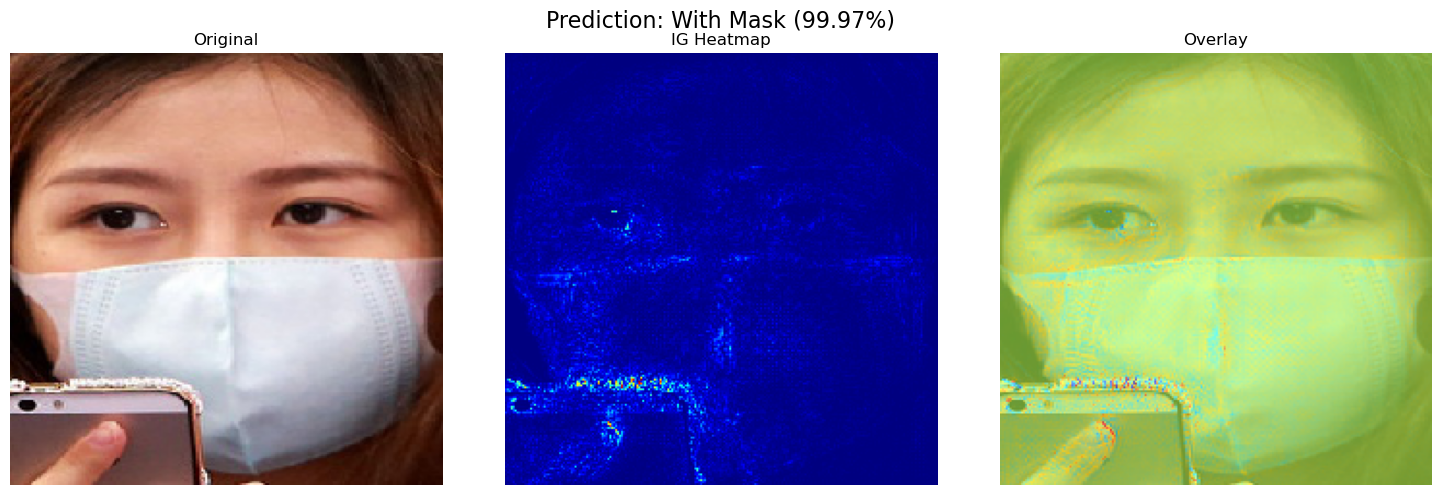

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


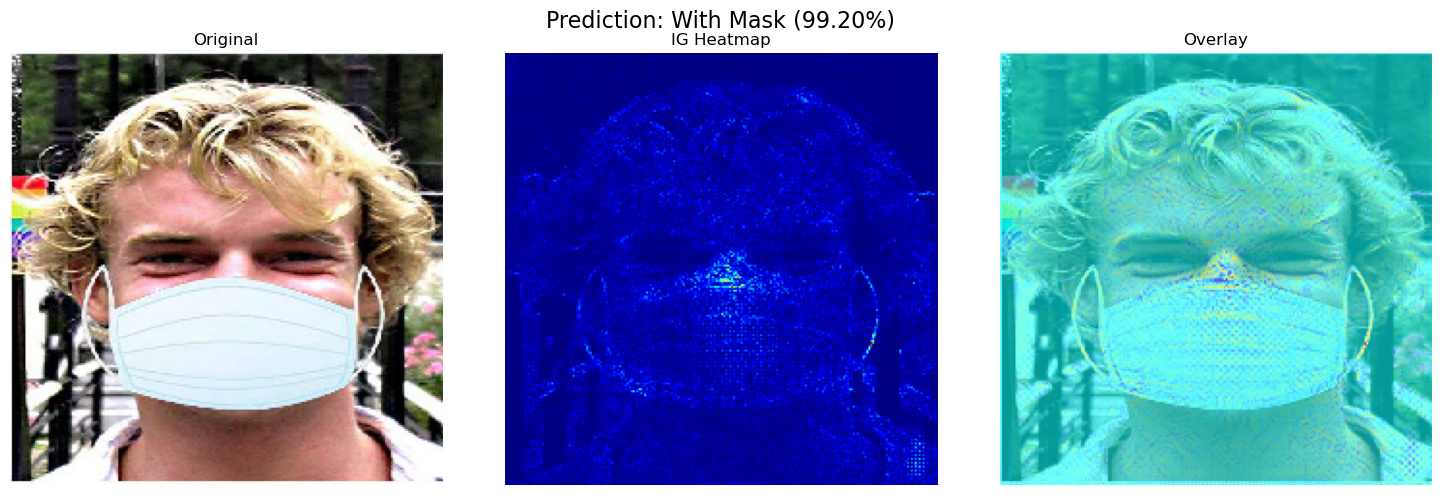

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


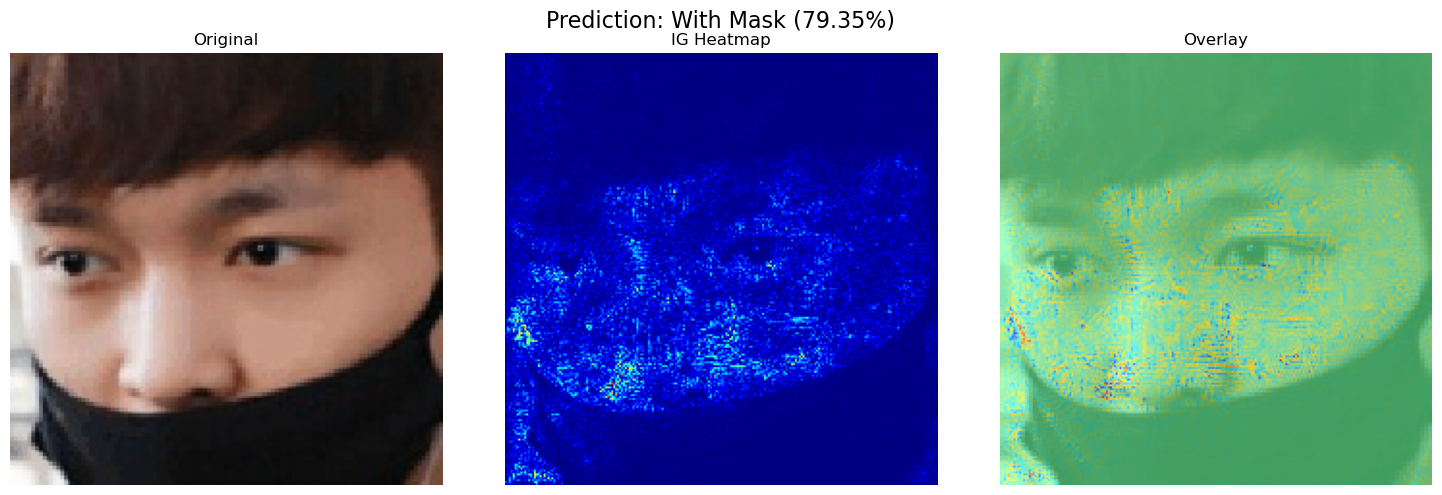

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


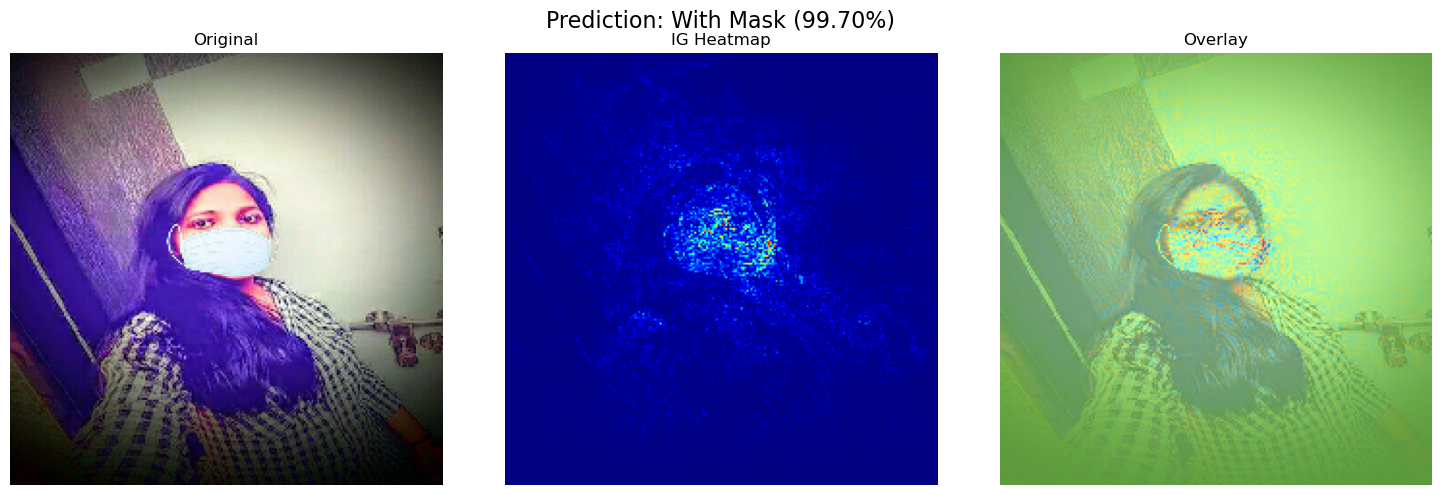

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


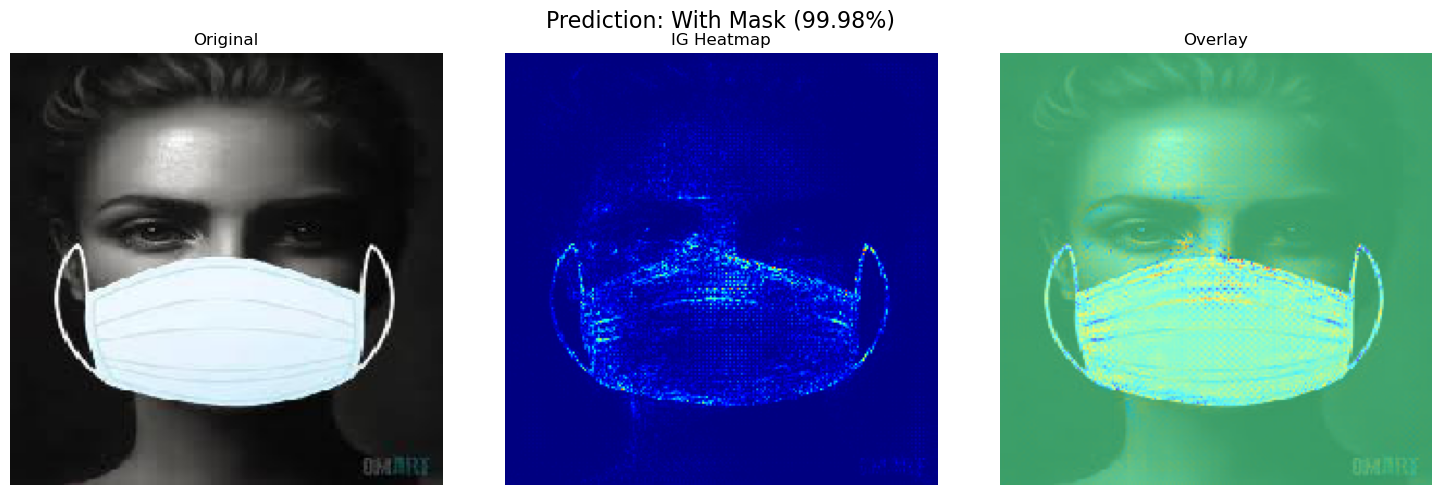

In [16]:
images, labels = next(test_data)
predict_and_visualize_igrads_unified(model, inputs=images, input_type="array", num_samples=5)


As we can see, this model is performing better at focousing in the face origion to detetmin wether a mask is wearon or not

### **Testing The Model On Test Data**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


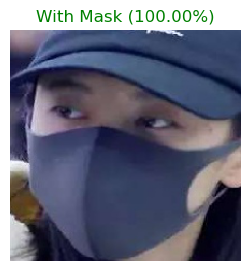

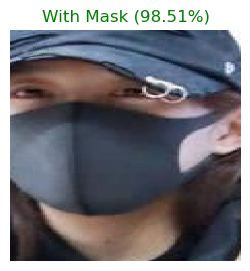

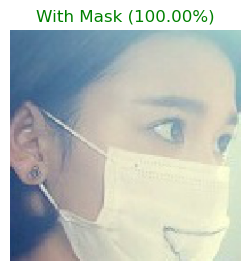

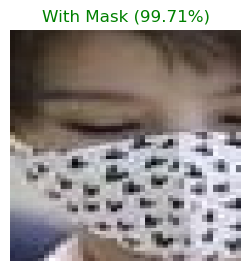

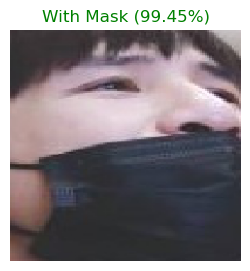

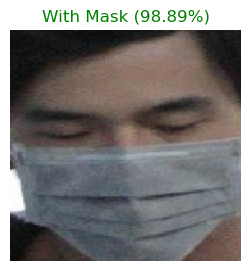

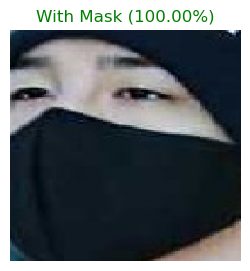

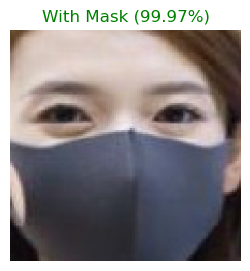

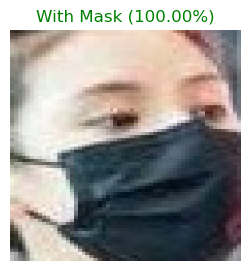

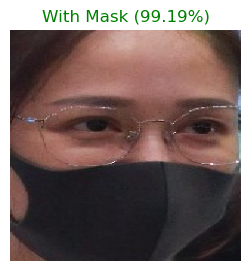

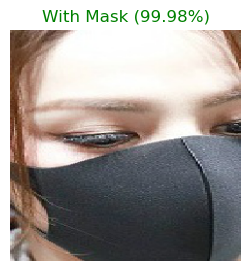

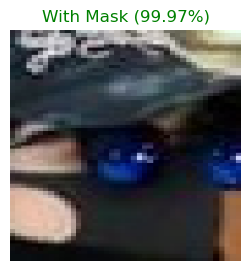

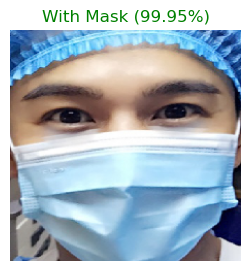

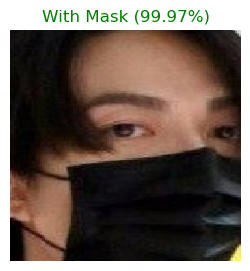

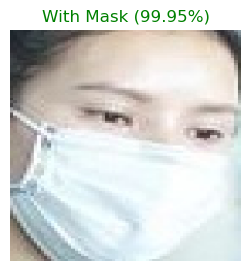

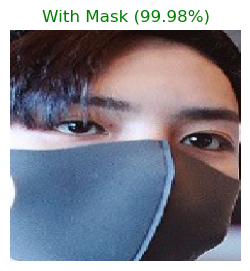

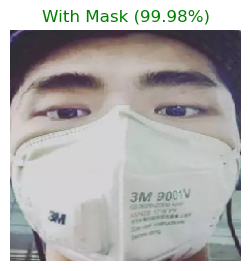

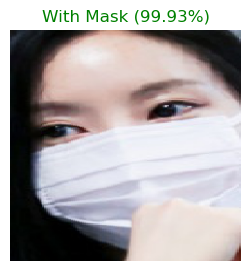

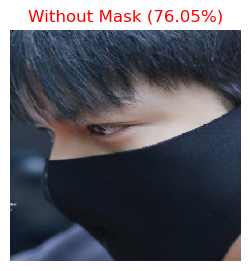

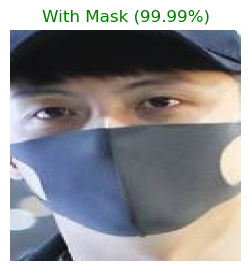

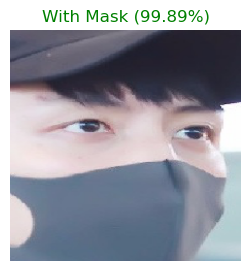

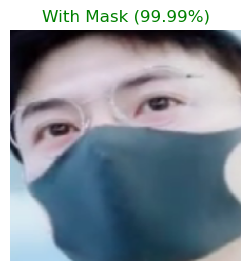

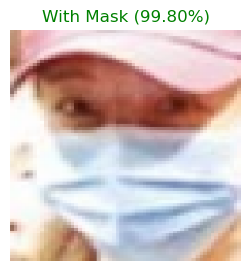

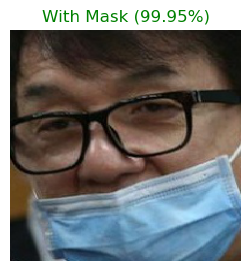

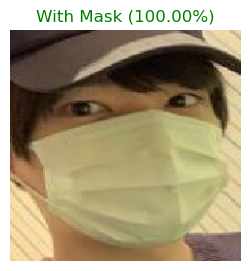

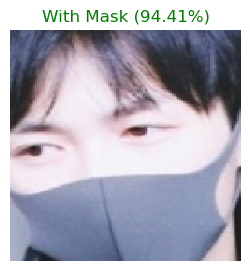

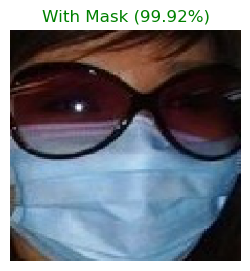

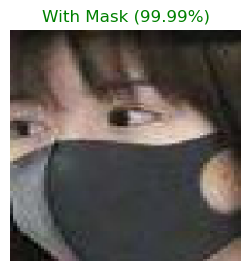

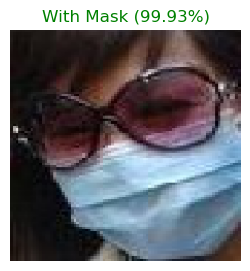

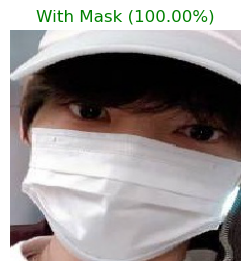

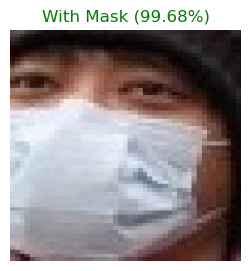

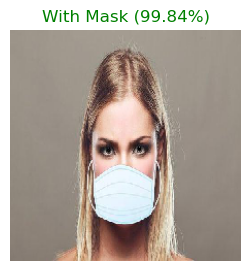

In [17]:
images, labels = next(test_data) 

predictions = model.predict(images)

for i in range(len(images)):
    img = images[i]
    true_label = int(labels[i])
    pred = predictions[i][0]

    if pred < 0.5:
        predicted_label = "With Mask"
        confidence = (1 - pred) * 100
        color = 'green'
    else:
        predicted_label = "Without Mask"
        confidence = pred * 100
        color = 'red'

    title = f"{predicted_label} ({confidence:.2f}%)"

    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.title(title, color=color)
    plt.axis('off')
    plt.show()


#### **Model Evaluation On Unseen Data**

In [18]:
def load_images_from_urls(urls, img_size):
    images = []
    for url in urls:
        try:
            response = requests.get(url, timeout=10)
            img = Image.open(BytesIO(response.content)).convert('RGB')
            img = img.resize((img_size, img_size))
            img_array = np.array(img) / 255.0
            images.append(img_array)
        except Exception as e:
            print(f"Could not load image from {url}: {e}")
    return images


In [19]:
def predict_from_url(url):
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content)).convert('RGB')
        img_resized = img.resize((224, 224))
        
        img_array = img_to_array(img_resized) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        pred = model.predict(img_array)[0][0]

        if pred < 0.5:
            label = "With Mask"
            confidence = (1 - pred) * 100
            color = 'green'
        else:
            label = "Without Mask"
            confidence = pred * 100
            color = 'red'

        title = f"{label} ({confidence:.2f}%)"

        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(title, color=color)
        plt.axis('off')
        plt.show()
        
    except Exception as e:
        print(f" Error : {e}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


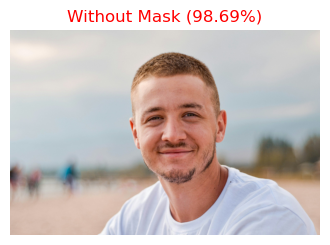

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


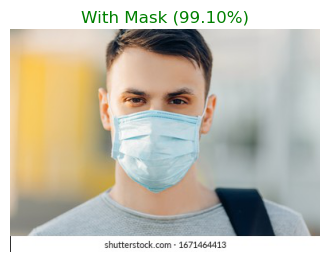

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


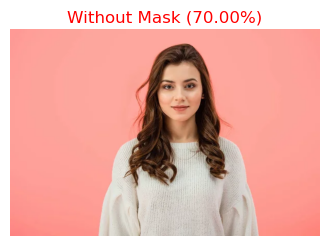

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


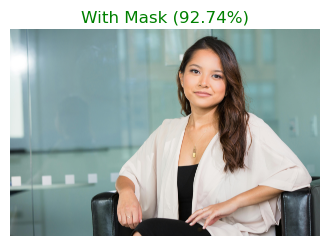

In [20]:
urls = [
    "https://images.unsplash.com/photo-1564564244660-5d73c057f2d2?fm=jpg&q=60&w=3000",
    "https://www.shutterstock.com/image-photo/young-man-background-open-air-260nw-1671464413.jpg",
    "https://st4.depositphotos.com/13193658/25036/i/450/depositphotos_250363326-stock-photo-smiling-attractive-woman-white-sweater.jpg",
    "https://images.pexels.com/photos/1181690/pexels-photo-1181690.jpeg?cs=srgb&dl=pexels-divinetechygirl-1181690.jpg&fm=jpg",
]

for url in urls:
    predict_from_url(url)


As we can see in the final picture, this pre-trained model also struggles to detect faces that are not in **standard positions, distances, or angles relative to the camera** — especially considering the nature of the dataset it was trained on.